In [77]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import keras

from keras.models import Sequential
from keras.layers import UpSampling2D, Reshape, Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, InputLayer
from keras.layers import merge
from keras import Model
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.layers import Input
from keras.layers import Convolution2D, ZeroPadding2D

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.engine import Layer, InputSpec


%matplotlib inline

In [78]:
class LRN2D(Layer):

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
        if n % 2 == 0:
            raise NotImplementedError(
                "LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__(**kwargs)
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = K.shape(X)
        half_n = self.n // 2
        input_sqr = K.square(X)

        extra_channels = K.zeros((b, ch + 2 * half_n, r, c))
        input_sqr = K.concatenate([extra_channels[:, :half_n, :, :],
                                   input_sqr,
                                   extra_channels[:, half_n + ch:, :, :]],
                                  axis=1)
        scale = self.k

        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i + ch, :, :]
        scale = scale ** self.beta

        return X / scale

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN2D, self).get_config()

In [79]:
NB_CLASS = 1000         # number of classes
LEARNING_RATE = 0.01
MOMENTUM = 0.9
GAMMA = 0.1
DROPOUT = 0.5
WEIGHT_DECAY = 0.0005   # L2 regularization factor
USE_BN = True           # whether to use batch normalization
# Theano - 'th' (channels, width, height)
# Tensorflow - 'tf' (width, height, channels)
DIM_ORDERING = 'th'

In [80]:
def conv2D_bn(x, nb_filter, nb_row, nb_col,
              border_mode='same', subsample=(1, 1),
              activation='relu', batch_norm=USE_BN,
              weight_decay=WEIGHT_DECAY, dim_ordering=DIM_ORDERING):
    '''
        Info:
            Function taken from the Inceptionv3.py script keras github
            Utility function to apply to a tensor a module conv + BN
            with optional weight decay (L2 weight regularization).
    '''
    if weight_decay:
        W_regularizer = regularizers.l2(weight_decay)
        b_regularizer = regularizers.l2(weight_decay)
    else:
        W_regularizer = None
        b_regularizer = None

    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample,
                      activation=activation,
                      border_mode=border_mode,
                      W_regularizer=W_regularizer,
                      b_regularizer=b_regularizer,
                      dim_ordering=dim_ordering)(x)
    x = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(x)

    if batch_norm:
        x = LRN2D()(x)
        x = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(x)

    return x


def create_model():

    # Define image input layer
    if DIM_ORDERING == 'th':
        INP_SHAPE = (3, 224, 224)  # 3 - Number of RGB Colours
        img_input = Input(shape=INP_SHAPE)
        CONCAT_AXIS = 1
    elif DIM_ORDERING == 'tf':
        INP_SHAPE = (224, 224, 3)  # 3 - Number of RGB Colours
        img_input = Input(shape=INP_SHAPE)
        CONCAT_AXIS = 3
    else:
        raise Exception('Invalid dim ordering: ' + str(DIM_ORDERING))

    # Channel 1 - Conv Net Layer 1
    x = conv2D_bn(img_input, 3, 11, 11, subsample=(1, 1), border_mode='same')
    x = MaxPooling2D(
        strides=(
            4, 4), pool_size=(
                4, 4), dim_ordering=DIM_ORDERING)(x)
    x = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(x)

    # Channel 2 - Conv Net Layer 1
    y = conv2D_bn(img_input, 3, 11, 11, subsample=(1, 1), border_mode='same')
    y = MaxPooling2D(
        strides=(
            4, 4), pool_size=(
                4, 4), dim_ordering=DIM_ORDERING)(y)
    y = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(y)

    # Channel 1 - Conv Net Layer 2
    x = conv2D_bn(x, 48, 55, 55, subsample=(1, 1), border_mode='same')
    x = MaxPooling2D(
        strides=(
            2, 2), pool_size=(
                2, 2), dim_ordering=DIM_ORDERING)(x)
    x = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(x)

    # Channel 2 - Conv Net Layer 2
    y = conv2D_bn(y, 48, 55, 55, subsample=(1, 1), border_mode='same')
    y = MaxPooling2D(
        strides=(
            2, 2), pool_size=(
                2, 2), dim_ordering=DIM_ORDERING)(y)
    y = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(y)

    # Channel 1 - Conv Net Layer 3
    x = conv2D_bn(x, 128, 27, 27, subsample=(1, 1), border_mode='same')
    x = MaxPooling2D(
        strides=(
            2, 2), pool_size=(
                2, 2), dim_ordering=DIM_ORDERING)(x)
    x = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(x)

    # Channel 2 - Conv Net Layer 3
    y = conv2D_bn(y, 128, 27, 27, subsample=(1, 1), border_mode='same')
    y = MaxPooling2D(
        strides=(
            2, 2), pool_size=(
                2, 2), dim_ordering=DIM_ORDERING)(y)
    y = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(y)

    # Channel 1 - Conv Net Layer 4
    x1 = merge([x, y], mode='concat', concat_axis=CONCAT_AXIS)
    x1 = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(x1)
    x1 = conv2D_bn(x1, 192, 13, 13, subsample=(1, 1), border_mode='same')

    # Channel 2 - Conv Net Layer 4
    y1 = merge([x, y], mode='concat', concat_axis=CONCAT_AXIS)
    y1 = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(y1)
    y1 = conv2D_bn(y1, 192, 13, 13, subsample=(1, 1), border_mode='same')

    # Channel 1 - Conv Net Layer 5
    x2 = merge([x1, y1], mode='concat', concat_axis=CONCAT_AXIS)
    x2 = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(x2)
    x2 = conv2D_bn(x2, 192, 13, 13, subsample=(1, 1), border_mode='same')

    # Channel 2 - Conv Net Layer 5
    y2 = merge([x1, y1], mode='concat', concat_axis=CONCAT_AXIS)
    y2 = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(y2)
    y2 = conv2D_bn(y2, 192, 13, 13, subsample=(1, 1), border_mode='same')

    # Channel 1 - Cov Net Layer 6
    x3 = conv2D_bn(x2, 128, 27, 27, subsample=(1, 1), border_mode='same')
    x3 = MaxPooling2D(
        strides=(
            2, 2), pool_size=(
                2, 2), dim_ordering=DIM_ORDERING)(x3)
    x3 = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(x3)

    # Channel 2 - Cov Net Layer 6
    y3 = conv2D_bn(y2, 128, 27, 27, subsample=(1, 1), border_mode='same')
    y3 = MaxPooling2D(
        strides=(
            2, 2), pool_size=(
                2, 2), dim_ordering=DIM_ORDERING)(y3)
    y3 = ZeroPadding2D(padding=(1, 1), dim_ordering=DIM_ORDERING)(y3)

    # Channel 1 - Cov Net Layer 7
    x4 = merge([x3, y3], mode='mul', concat_axis=CONCAT_AXIS)
    x4 = Flatten()(x4)
    x4 = Dense(2048, activation='relu')(x4)
    x4 = Dropout(DROPOUT)(x4)

    # Channel 2 - Cov Net Layer 7
    y4 = merge([x3, y3], mode='mul', concat_axis=CONCAT_AXIS)
    y4 = Flatten()(y4)
    y4 = Dense(2048, activation='relu')(y4)
    y4 = Dropout(DROPOUT)(y4)

    # Channel 1 - Cov Net Layer 8
    x5 = merge([x4, y4], mode='mul')
    x5 = Dense(2048, activation='relu')(x5)
    x5 = Dropout(DROPOUT)(x5)

    # Channel 2 - Cov Net Layer 8
    y5 = merge([x4, y4], mode='mul')
    y5 = Dense(2048, activation='relu')(y5)
    y5 = Dropout(DROPOUT)(y5)

    # Final Channel - Cov Net 9
    xy = merge([x5, y5], mode='mul')
    xy = Dense(output_dim=NB_CLASS,
               activation='softmax')(xy)

    return xy, img_input, CONCAT_AXIS, INP_SHAPE, DIM_ORDERING




In [82]:
# Create the Model
xy, img_input, CONCAT_AXIS, INP_SHAPE, DIM_ORDERING = create_model()

# Create a Keras Model - Functional API
model = Model(input=img_input,
              output=[xy])
model.summary()

# Save a PNG of the Model Build
SVG(model_to_dot(model).create(prog='dot', format='svg'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy')
print('Model Compiled')

/home/nicoroble/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (11, 11), activation="relu", strides=(1, 1), padding="same", data_format="channels_first", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
/home/nicoroble/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:25: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D(padding=(1, 1), data_format="channels_first")`
/home/nicoroble/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D(padding=(1, 1), data_format="channels_first")`
/home/nicoroble/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:53: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(strides=(4, 4), pool_size=(4, 4), dat

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 3, 224, 224)  0                                            
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 3, 224, 224)  1092        input_21[0][0]                   
__________________________________________________________________________________________________
conv2d_148 (Conv2D)             (None, 3, 224, 224)  1092        input_21[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_434 (ZeroPadding (None, 3, 226, 226)  0           conv2d_147[0][0]                 
__________________________________________________________________________________________________
zero_paddi

/home/nicoroble/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:155: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/nicoroble/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:157: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=1000)`
/home/nicoroble/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


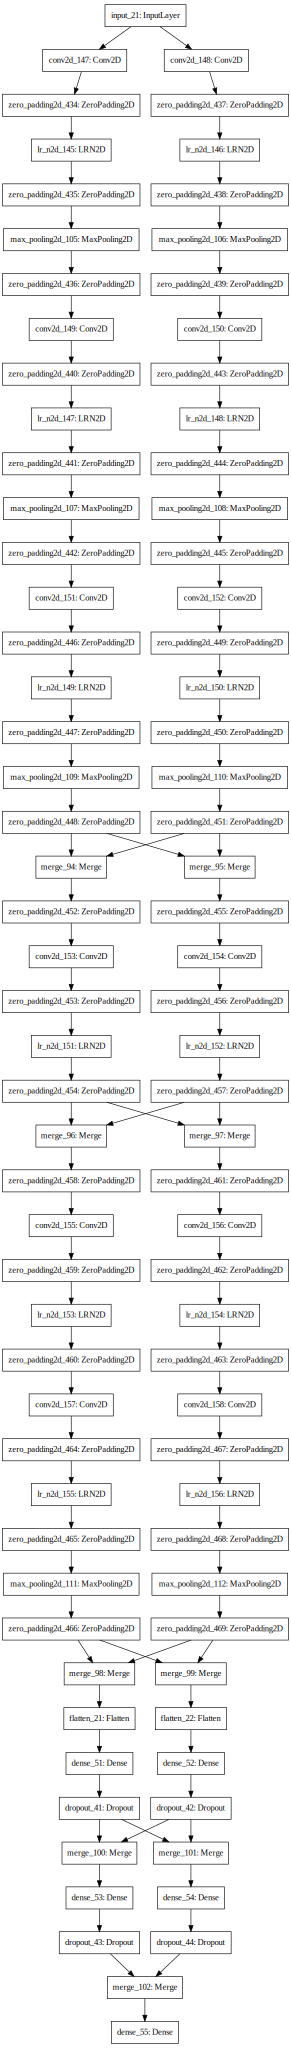

In [83]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))